In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import  glob
import seaborn as sns

tocategory = lambda col: pd.Categorical(col)
underscoretospace = lambda x: x.replace("_", " ") if type(x) is str else x
def q5(x): return x.quantile(.05)
def q95(x): return x.quantile(.95)

In [11]:
filenames = glob.glob("data/lsb.*.r*")
params = ["Algorithm", "Max threads", "Graph nodes"];

In [12]:
def get_df(filename):
    return (pd
      .read_csv(filename, sep=" ", comment="#", skipinitialspace=True, index_col="id")
      .applymap(underscoretospace)
      .dropna("columns", "all")
    )
df = pd.concat(get_df(filename) for filename in filenames)
df[["Algorithm", "Graph_name"]] = df[["Algorithm", "Graph_name"]].apply(tocategory)
df.columns = df.columns.map(underscoretospace)

In [13]:
df.head(5)

,Algorithm,Graph nodes,Graph name,Max threads,run,time,overhead
id,,,,,,,
0,Sequential Kruskal,100,Erdos-Renyi random,1,0,1052.479004,0
1,Sequential Kruskal,100,Erdos-Renyi random,1,1,771.540039,0
2,Sequential Kruskal,100,Erdos-Renyi random,1,2,745.734375,0
3,Sequential Kruskal,100,Erdos-Renyi random,1,3,740.649902,0
4,Sequential Kruskal,100,Erdos-Renyi random,1,4,731.659180,0


In [14]:
df.tail(5)

,Algorithm,Graph nodes,Graph name,Max threads,run,time,overhead
id,,,,,,,
145,Sollin,10000,Erdos-Renyi random,1,45,991839.698242,0
146,Sollin,10000,Erdos-Renyi random,1,46,995585.628418,0
147,Sollin,10000,Erdos-Renyi random,1,47,992295.277832,0
148,Sollin,10000,Erdos-Renyi random,1,48,987817.894531,0
149,Sollin,10000,Erdos-Renyi random,1,49,999530.880859,0


In [15]:
timequantiles = df.groupby(params).agg([q5, q95])["time"]
df_timequantiles =  timequantiles.loc[map(tuple, df[params].values)]

In [16]:
summary = (df[params + ["time"]]
    [(df.time >= df_timequantiles["q5"].values) & (df.time <= df_timequantiles["q95"].values)]
    .groupby(params).agg(["median", "mean", "min", "max", "std"])
)

In [17]:
summary

time                \
                                                  median          mean   
Algorithm          Max threads Graph nodes                               
Filter Kruskal     1           100          4.069849e+02  4.679321e+02   
                               1000         3.460879e+03  3.505209e+03   
                               10000        4.406488e+04  4.581769e+04   
                               264346       1.611217e+06  1.611088e+06   
                   2           100          6.662898e+02  6.672836e+02   
                               1000         4.270071e+03  4.387476e+03   
                               10000        4.807505e+04  4.843473e+04   
                               264346       1.640159e+06  1.662824e+06   
                   4           100          7.136501e+02  7.127412e+02   
                               1000         4.201774e+03  4.239929e+03   
                               10000        4.473819e+04  4.585466e+04   
                               264346       1.638559e+06  1.651262e+06   
                   8           100          8.111235e+02  7.996016e+02   
                               1000         4.478523e+03  4.597040e+03   
                               10000        4.451981e+04  4.590796e+04   
                               264346       1.700548e+06  1.721554e+06   
                   16          100          9.209268e+02  9.056160e+02   
                               1000         4.897383e+03  4.883462e+03   
                               10000        4.257943e+04  4.292444e+04   
                               264346       1.710436e+06  1.700992e+06   
                   32          100          1.355640e+03  1.387086e+03   
                               1000         7.324791e+03  7.012427e+03   
                               10000        4.933678e+04  4.976531e+04   
                               264346       1.976940e+06  1.975622e+06   
Sequential Kruskal 1           100          2.592988e+02  3.883672e+02   
                               1000         3.259455e+03  3.269202e+03   
                               10000        5.025944e+04  5.047968e+04   
                               264346       7.439345e+05  7.524875e+05   
                   2           100          2.250388e+02  2.270525e+02   
                               1000         2.576913e+03  2.566770e+03   
...                                                  ...           ...   
parallel sollin AL 1           100          2.620934e+03  2.639676e+03   
                               1000         3.894531e+04  3.898502e+04   
                               10000        6.386026e+05  6.453160e+05   
                               264346       4.437349e+06  4.443471e+06   
                   2           100          3.689985e+03  3.691900e+03   
                               1000         4.719047e+04  4.411337e+04   
                               10000        5.171222e+05  5.362407e+05   
                               264346       3.773146e+06  3.816719e+06   
                   4           100          3.769798e+03  3.778240e+03   
                               1000         4.385887e+04  4.387835e+04   
                               10000        5.259541e+05  5.159875e+05   
                               264346       3.337829e+06  3.331514e+06   
                   8           100          3.934180e+03  3.952530e+03   
                               1000         4.477272e+04  4.398273e+04   
                               10000        5.423260e+05  5.442328e+05   
                               264346       3.559800e+06  3.600227e+06   
                   16          100          6.314973e+03  5.929998e+03   
                               1000         5.066324e+04  5.093686e+04   
                               10000        5.760929e+05  5.804003e+05   
                               264346       4.046976e+06  4.061886e+06   
                   32          100          7.365527e+03

In [18]:
g_idx = ["Graph nodes", "Graph name"]
graphs = df[g_idx].drop_duplicates().values

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


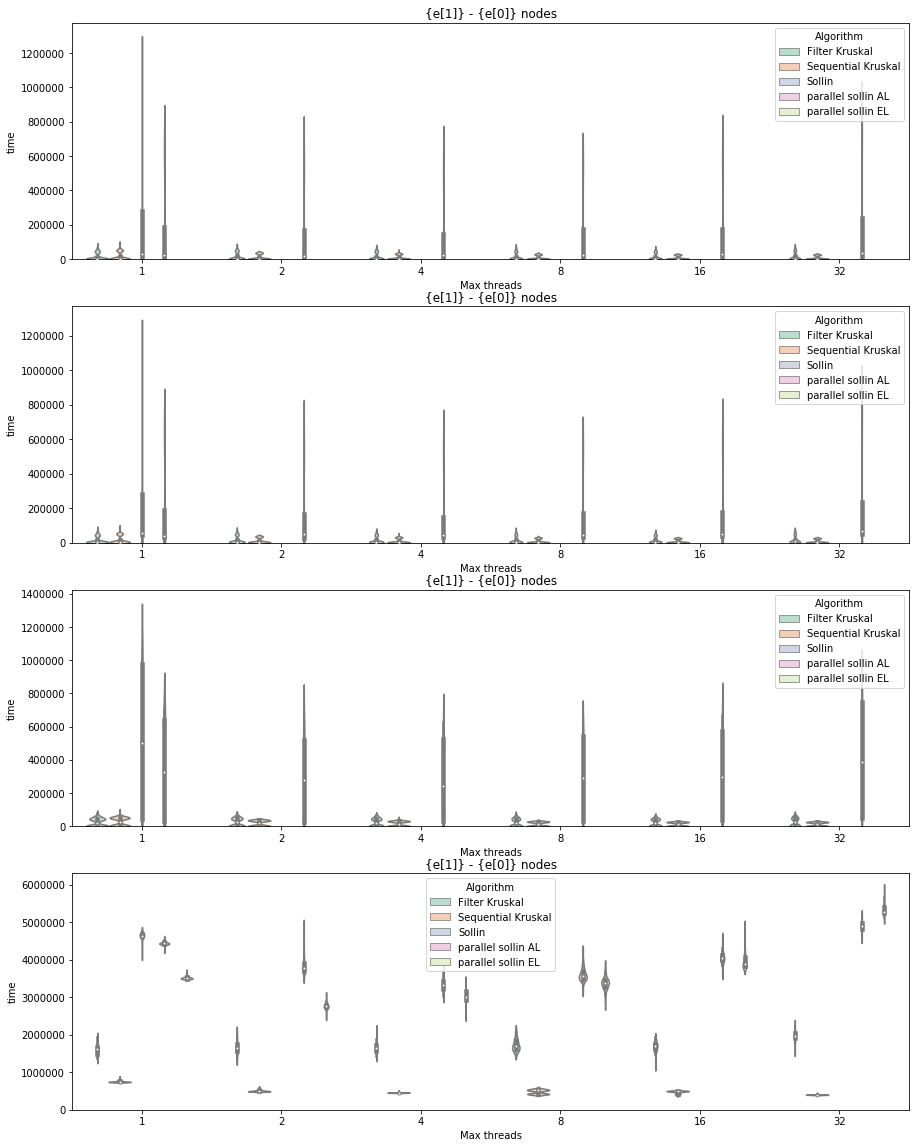

In [21]:
fig, ax = plt.subplots(nrows=len(graphs),figsize=(15,5*len(graphs)))
for i, e in enumerate(graphs):
    sns.violinplot(
        x="Max threads", y="time", hue="Algorithm", 
        data=df[df[g_idx].values == e], 
        palette="Pastel2", ax=ax[i]
    )
    ax[i].set_title("{e[1]} - {e[0]} nodes")
    ax[i].set_ylim(0,)

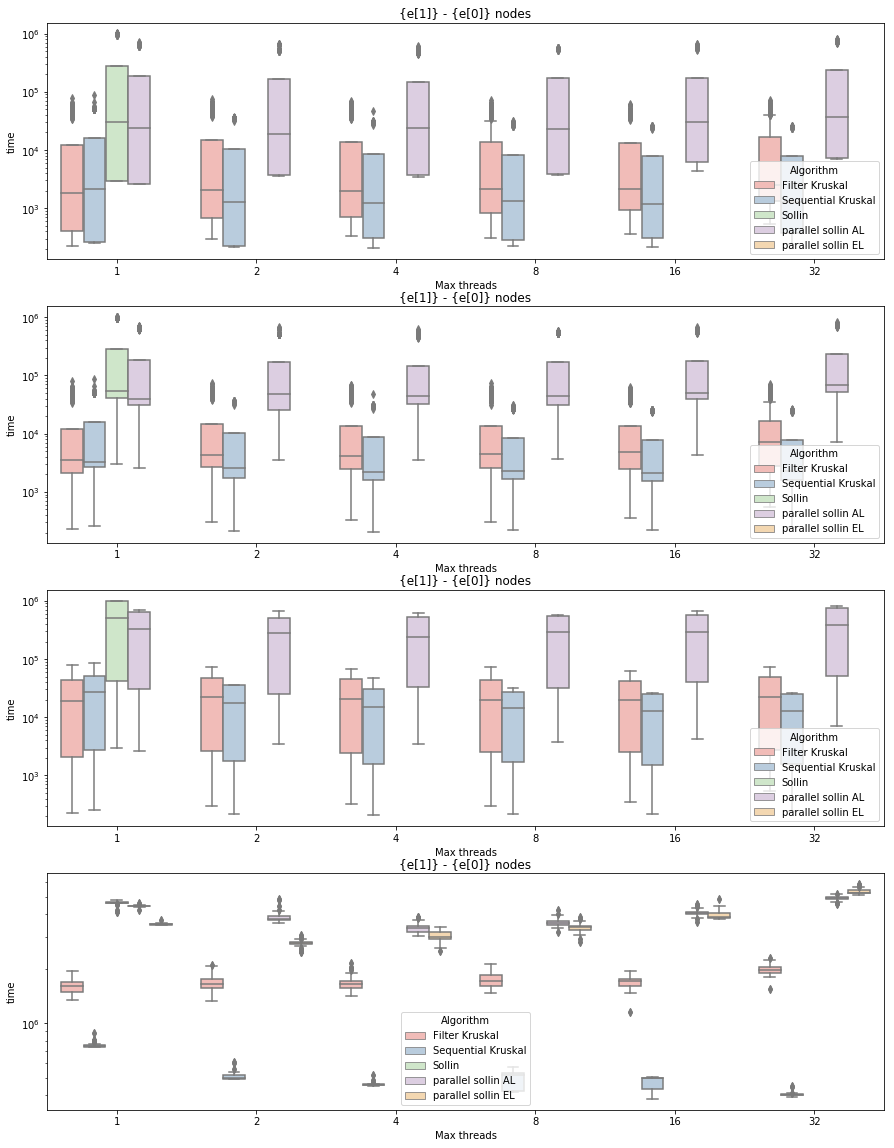

In [22]:
fig, ax = plt.subplots(nrows=len(graphs),figsize=(15,5*len(graphs)))
for i, e in enumerate(graphs):
    sns.boxplot(
        x="Max threads", y="time", hue="Algorithm", 
        data=df[df[g_idx].values == e], 
        palette="Pastel1", ax=ax[i]
    ).set(yscale="log")
    ax[i].set_title("{e[1]} - {e[0]} nodes")